In [86]:
### Custom Environment
import gym
import numpy as np
import traci
import math
from os import path

class SumoEnv(gym.Env):
  def __init__(self):
    traci.start(["sumo", "-c", path.abspath("../SUMO/test.sumocfg")])
    
    ## SUMO VARIABLES ##
    self.bus_stop_positions = [[123, 974, 1872, 2764], [123, 827, 1742, 2702, 3592]]
    self.bus_locations={"-overlap": "123", "-R2": "259", "-R1": "125", "-R0": "267", "-L3": "117", "-L2": "110", "-L1": "123", "-L0": "120"}
    self.bus_ids=["bus_r_0_0", "bus_r_0_1", "bus_r_0_2", "bus_r_0_3", "bus_r_0_4"]
    
    # self.route_names = [["-overlap", "-R2", "-R1", "-R0"], ["-overlap", "-L3", "-L2", "-L1", "-L0"]]
    self.route_lengths = [3591, 4697]
    # self.route_junctions={"J1": ["-L0", "-R0", "-overlap"], "J2": ["-R0", "-R1"], "J3": ["-R1", "-R2"], "J4": ["-L3", "-R2", "-overlap"], "J5": ["-L0", "-L1"], "J7": ["-L1", "-L2"], "J8": ["-L2", "-L3"]}
    
    self.wait_time = 0
    self.delta_speed = 0.1
    self.min_speed_before_change = 30
    self.action_delta_speed = {0: (1-self.delta_speed), 2: (1+self.delta_speed)}

    ## GYM VARIABLES ##
    self.bus_num = 5
    bus_stops_num = 4
    bus_speed_max = 50

    #actions: [b1, b2 (...)] # each action is either 0 = slow down, 1 = keep speed, 2 = speed up
    self.action_space = gym.spaces.Box(low=np.array([0]*self.bus_num), high=np.array([2]*self.bus_num), shape=(self.bus_num,), dtype=np.float32)
    
    #states: [avg_wait_time, b1_speed, b1_pos, b2_speed, b2_pos, (...),  bs1_pos, bs2_pos, bs3_pos, bs4_pos]
    wait_max = 100000
    low_obs = np.zeros([1 + 2*self.bus_num + bus_stops_num])
    high_obs = np.array([wait_max] + [bus_speed_max, self.route_lengths[0]]*self.bus_num + [self.route_lengths[0]]*bus_stops_num)
    self.observation_space = gym.spaces.Box(low=low_obs, high=high_obs, shape=(1 + 2*self.bus_num + bus_stops_num,), dtype=np.float32)

    self.max_steps = 500
    self.current_step = 0

  def reset(self):
    pass
  
  def step(self, action):
    try:
      next_state = self.sumo_step()

      #set action for each bus: 0 = slow down, 1 = keep speed, 2 = speed up
      vehicles_length = len(traci.vehicle.getIDList())
      
      for i, bus_action in enumerate(action):
        if bus_action == 1 or i >= vehicles_length: break
        bus_id = self.bus_ids[i]
        bus_distance_driven = traci.vehicle.getDistance(bus_id)
        
        if np.sign(bus_distance_driven) == -1: break ## if bus hasnt driven yet, skip

        bus_route = traci.vehicle.getRouteID(bus_id)
        bus_position = round(bus_distance_driven % (self.route_lengths[0] if (bus_route == "r_0") else self.route_lengths[1]), 3)
        nearest_bus_stop_position = self._find_nearest(self.bus_stop_positions[0 if bus_route == "r_0" else 1], bus_position)
        bus_speed_km_t = traci.vehicle.getSpeed(bus_id)*3.6 # m/s to km/h
        
        interval = [-22, 3]
        # change speed if speed > min_speed_before_change and bus is not at a bus stop
        if bus_speed_km_t > self.min_speed_before_change and not (bus_position > nearest_bus_stop_position + interval[0] and bus_position < nearest_bus_stop_position + interval[1]):
          new_speed = self.action_delta_speed[bus_action] * traci.vehicle.getSpeed(bus_id) # speed is in m/s
          traci.vehicle.slowDown(bus_id, new_speed, 1) # smoothly changes to new speed over 1 second

      # reward are given if the new waiting time is strictly lower, otherwise punished
      reward = 1 if next_state[0] < self.wait_time else -1

      # set the wait time to the current wait time
      self.wait_time = next_state[0]

      # check if done
      self.current_step += 1
      done = False
      if(self.current_step >= self.max_steps):
        done = True

      return next_state, reward, done, {}

    except Exception as e: # if there is an error, close the simulation
      print("An error occurred. Closing simulation.")
      print("Error: ", e)
      traci.close()
    
  def render(self):
    pass

  def close(self):
    traci.close()

  def seed(self, seed=None):
    pass

  ## SUMO FUNCTIONS
  def sumo_step(self):
    # state [avg_wait_time, b1_speed, b1_pos, b2_speed, b2_pos, (...),  bs1_pos, bs2_pos, bs3_pos, bs4_pos]
    new_state = [0] * (1 + 2 * self.bus_num) + self.bus_stop_positions[0]
    personsWaitingTimeList = []
    traci.simulationStep()

    vehicles = traci.vehicle.getIDList()
    persons = traci.person.getIDList()

    ## finds the average waiting time
    for i in range(0,len(persons)):
      personWaitingTime = traci.person.getWaitingTime(persons[i])
      personsWaitingTimeList.append(personWaitingTime)

    persons_waiting_num = len(personsWaitingTimeList)
    new_state[0] = round(sum(personsWaitingTimeList) / persons_waiting_num, 3) if persons_waiting_num > 0 or not np.isnan(persons_waiting_num) or not np.isnan(personsWaitingTimeList) else 0.0

    ## finds bus speed and position
    for j in range(0,len(vehicles)):
      vehicleId = vehicles[j]
      if traci.vehicle.getRouteID(vehicleId) != "r_0": continue

      vehicleSpeed = traci.vehicle.getSpeed(vehicleId)*3.6 # m/s to km/h
      vehiclePosition = traci.vehicle.getDistance(vehicleId) % (self.route_lengths[0] 
                        if (traci.vehicle.getRouteID(vehicleId) == "r_0") else self.route_lengths[1])
      new_state[1 + 2*j] = round(vehicleSpeed, 2)
      new_state[2 + 2*j] = round(vehiclePosition, 2)
    return new_state
  
  def _find_nearest(self, array, value):
    idx = np.searchsorted(array, value, side="left")
    if (idx == len(array) and math.fabs(value - (array[0] + array[idx-1])) < math.fabs(value - array[idx-1])):
      print("first case!")
      return array[0]
    elif idx > 0 and idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx]):
      print("second case!")
      return array[idx-1]
    else:
      print("last case!")
      return array[idx]

In [94]:
traci.close()

In [75]:
env = SumoEnv()

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [95]:
import unittest

class TestSumoEnv(unittest.TestCase):
  def setUp(self): # setup the variables here for every test
    self.env = SumoEnv()

  def test_initializations(self):
    self.env.reset()
    action = [1, 1, 1, 1, 1]
    state, reward, done, _ = self.env.step(action)
    self.assertEqual(len(state), 15)
    self.assertEqual(state, [0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 123, 974, 1872, 2764])
    self.assertEqual(reward, -1)
    self.assertFalse(done)
    self.env.close()

  def test_find_nearest_function(self):
    self.env.reset()
    self.assertEqual(self.env._find_nearest([350, 700, 950, 1600, 2600], 3100), 350) # goes into first if statement
    self.assertEqual(self.env._find_nearest([350, 700, 950, 1600, 2600], 2000), 1600) # goes into second if statement
    self.assertEqual(self.env._find_nearest([350, 700, 950, 1600, 2600], 2700), 2600) # goes into second if statement
    self.assertEqual(self.env._find_nearest([2, 4, 6, 8, 10], 11), 10) # goes into second if statement
    self.assertEqual(self.env._find_nearest([2, 4, 6, 8, 10], 3.6), 4) # goes into else statement
    self.env.close()

unittest.main(argv=[''], exit=False)

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


first case!
second case!
second case!
second case!
last case!
second case!


..
----------------------------------------------------------------------
Ran 2 tests in 7.253s

OK


In [23]:
traci.close()
env = SumoEnv()

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [30]:
# from stable_baselines3 import PPO
# from stable_baselines3.common.env_util import make_vec_env

# vec_env = make_vec_env(lambda: env, n_envs=2)
# model = PPO("MlpPolicy", vec_env, verbose=1, learning_rate=0.001, policy_kwargs=dict(net_arch=[64, 64]))
# model.learn(total_timesteps=10000)
# model.save("ppo_sumo")

# del model

# model = PPO.load("ppo_sumo")

# obs = vec_env.reset()
# while True:
#   action, _states = model.predict(obs)
#   obs, rewards, dones, info = vec_env.step(action)

Using cpu device


ValueError: Expected parameter loc (Tensor of shape (2, 5)) of distribution Normal(loc: torch.Size([2, 5]), scale: torch.Size([2, 5])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [334]:
while env.current_step < 50:
  next_state, reward, done, info = env.step([1]*env.bus_num)

next_state, reward, done, info = env.step([2]*env.bus_num)
print(f"{env.current_step}: ", next_state, reward, done, info)

# state [avg_wait_time, b1_speed, b1_pos, b2_speed, b2_pos, (...),  bs1_pos, bs2_pos, bs3_pos, bs4_pos]

109:  [37.561, 0.0, 978.28, 50.0, 448.69, 26.94, 34.54, 0, 0, 0, 0, 123, 974, 1872, 2764] 1 False {}


In [ ]:
traci.close()

In [12]:
### Custom Environment
import gym
import numpy as np

class ShopEnv(gym.Env):
  def __init__(self):

    self.max_capacity = 4000
    self.action_space = gym.spaces.Box(low=np.array([0]), high=np.array([self.max_capacity]), shape=(1,), dtype=np.float32)
    self.lead_time = 5 # controls the shape of the observation space
    self.obs_dim = 10 + self.lead_time
    obs_low = np.zeros([self.obs_dim])

    self.max_mean_daily_demand = 1000
    self.max_daily_holding_cost_per_unit = 20
    self.max_unit_selling_price = 5

    obs_high = np.array([self.max_capacity for _ in range(self.lead_time)] + [self.max_mean_daily_demand, self.max_unit_selling_price, self.max_daily_holding_cost_per_unit])
    self.observation_space = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

    self.rng = np.random.default_rng()

    self.current_obs = None
    self.episode_length_in_days = 90
    self.day_num = None

  def reset(self):
    mean_daily_demand = self.rng.uniform() * self.max_mean_daily_demand

    selling_price =  self.rng.uniform() * self.max_unit_selling_price
    buying_price = self.rng.uniform() * selling_price

    daily_holding_cost_per_unit = self.rng.uniform() * min(buying_price, self.max_daily_holding_cost_per_unit)

    self.current_obs = np.array([0 for _ in range(self.lead_time)] + [mean_daily_demand, selling_price, daily_holding_cost_per_unit])
    
    self.day_num = 0
    return self.current_obs
  
  def step(self, action):
    buys = min(action[0], self.max_capacity - np.sum(self.current_obs[:self.lead_time]))
    demand = self.rng.poisson(self.current_obs[self.lead_time])
    next_obs = np.concatenate((self.current_obs[1: self.lead_time], np.array([buys]), self.current_obs[self.lead_time:]))
    next_obs[0] += max(0, self.current_obs[0] - demand) # a part of an equation

    reward = (self.current_obs[self.lead_time + 1] * (self.current_obs[0] + self.current_obs[1] - next_obs[0]) - self.current_obs[self.lead_time + 2] * buys - self.current_obs[self.lead_time + 3] * (next_obs[0] - self.current_obs[1]))

    self.day_num += 1
    done = False
    if self.day_num >= self.episode_length_in_days:
      done = True
    
    self.current_obs = next_obs
    
    return self.current_obs, reward, done, # {} any additional information can be added to the agent here

  def render(self, mode="human"):
    pass # the box representation is good enough, no need to render any image

  def close(self):
    pass

  def seed(self, seed=None):
    pass




In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

class ShowerEnv(Env):
  def __init__(self):
    self.action_space = Discrete(3)
    self.observation_space = Box(low=np.array([0]), high=np.array([100]), dtype=np.float32)

    self.state = 38 + random.randint(-3, 3)
    self.shower_length = 60

  def step(self, action):
    self.state += action -1
    self.shower_length -= 1

    if self.state >= 37 and self.state <= 39:
      reward = 1
    else:
      reward = -1
    
    if self.shower_length <= 0:
      done = True
    else:
      done = False
    
    self.state += random.randint(-1, 1)
    info = {}
    return self.state, reward, done, info

  def render(self):
    pass
  
  def reset(self):
    self.state = 38 + random.randint(-3, 3)
    self.shower_length = 60
    return [self.state], {}

In [52]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [53]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [54]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [55]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [56]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


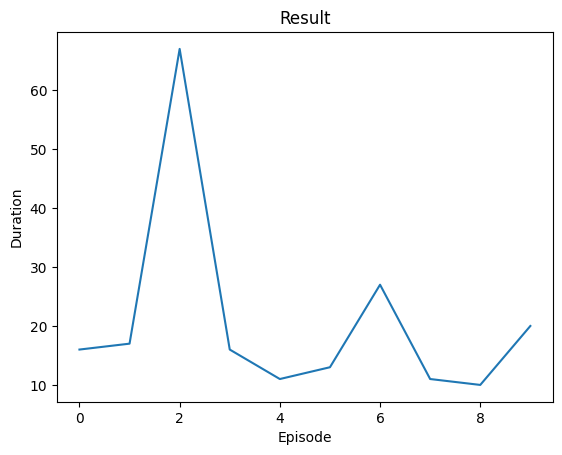

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [58]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 10

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()